Epoch 1/100
39/39 [==============================] - 6s 41ms/step - loss: 0.0131
Epoch 2/100
39/39 [==============================] - 2s 42ms/step - loss: 0.0048
Epoch 3/100
39/39 [==============================] - 2s 43ms/step - loss: 0.0040
Epoch 4/100
39/39 [==============================] - 2s 47ms/step - loss: 0.0039
Epoch 5/100
39/39 [==============================] - 2s 42ms/step - loss: 0.0035
Epoch 6/100
39/39 [==============================] - 2s 43ms/step - loss: 0.0033
Epoch 7/100
39/39 [==============================] - 2s 40ms/step - loss: 0.0034
Epoch 8/100
39/39 [==============================] - 1s 38ms/step - loss: 0.0032
Epoch 9/100
39/39 [==============================] - 2s 39ms/step - loss: 0.0032
Epoch 10/100
39/39 [==============================] - 2s 39ms/step - loss: 0.0029
Epoch 11/100
39/39 [==============================] - 2s 43ms/step - loss: 0.0029
Epoch 12/100
39/39 [==============================] - 2s 44ms/step - loss: 0.0025
Epoch 13/100
39/39 [=====

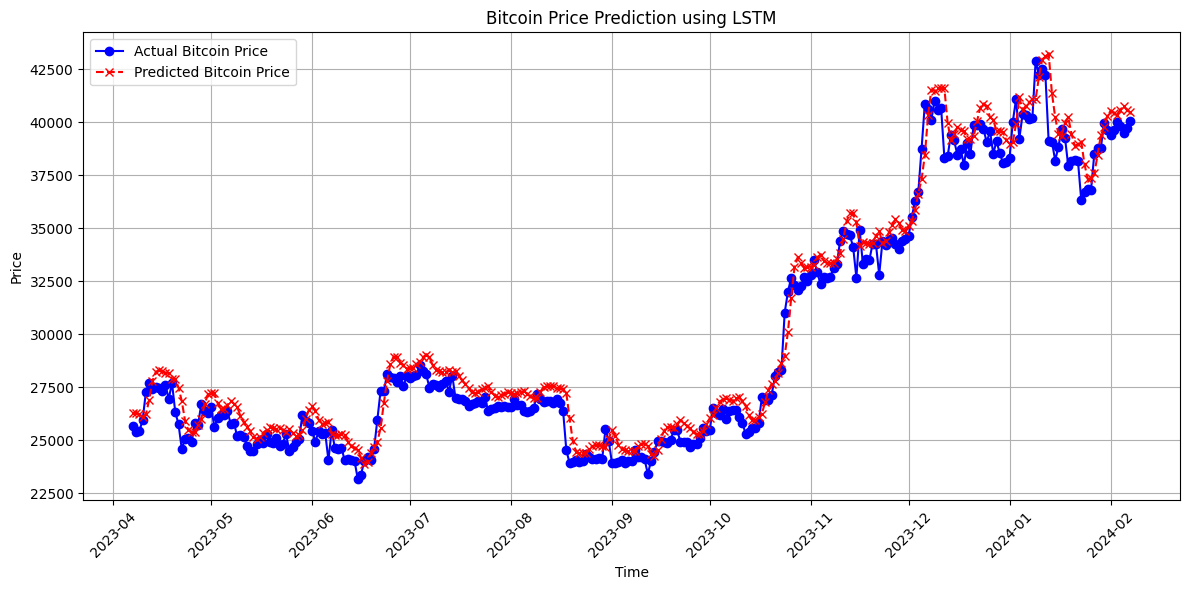

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Load Bitcoin price data
bitcoin_data = pd.read_csv('dataset/BitcoinData.csv', delimiter=';')

# Change the 'timestamp' column to datetime type
bitcoin_data['timestamp'] = pd.to_datetime(bitcoin_data['timestamp'])

# Ensure data is ordered by date
bitcoin_data = bitcoin_data.sort_values(by='timestamp', ascending=True)

# Define the set of features for the model
selected_features = bitcoin_data[['timestamp', 'open', 'high', 'low', 'close', 'volume']]

# Prepare data for normalization, excluding 'timestamp'
data_for_scaling = selected_features[['open', 'high', 'low', 'close', 'volume']].values

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(data_for_scaling)

# Combine normalized data with timestamps
normalized_df = pd.concat([selected_features['timestamp'].reset_index(drop=True), pd.DataFrame(normalized_data, columns=['open', 'high', 'low', 'close', 'volume'])], axis=1)

# Function to create sequences for LSTM input
def create_sequences(data, sequence_length=60):
    sequences, targets, sequence_dates = [], [], []
    for i in range(len(data) - sequence_length):
        sequence = data.iloc[i:i + sequence_length, 1:].values  # Exclude 'timestamp'
        target = data.iloc[i + sequence_length, -2]  # Target is 'close' price
        sequence_date = data.iloc[i + sequence_length, 0]  # Date for the sequence
        sequences.append(sequence)
        targets.append(target)
        sequence_dates.append(sequence_date)
    return np.array(sequences), np.array(targets), np.array(sequence_dates)

# Generate data sequences
sequence_length = 60
X, y, test_dates = create_sequences(normalized_df, sequence_length)

# Split data into training and test sets based on time sequence
test_size = int(0.2 * len(X))
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]
dates_test = test_dates[-test_size:]

# Define LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)  # Output layer for predicting the next 'close' price
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Predict prices
predicted_prices = model.predict(X_test)

# Inverse transform predictions to original price scale
dummy_predicted = np.zeros((len(predicted_prices), normalized_data.shape[1]))
dummy_predicted[:, -2] = predicted_prices[:, 0]  # Place predictions in the correct column
predicted_prices_original = scaler.inverse_transform(dummy_predicted)[:, -2]

# Inverse transform actual prices to original scale
dummy_actual = np.zeros((len(y_test), normalized_data.shape[1]))
dummy_actual[:, -2] = y_test
actual_prices_original = scaler.inverse_transform(dummy_actual)[:, -2]

# Calculate performance metrics
rmse = sqrt(mean_squared_error(actual_prices_original, predicted_prices_original))
r2 = r2_score(actual_prices_original, predicted_prices_original)

print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

# Visualize actual vs. predicted prices
plt.figure(figsize=(12, 6))
plt.plot(dates_test, actual_prices_original, color='blue', label='Actual Bitcoin Price', marker='o')
plt.plot(dates_test, predicted_prices_original, color='red', label='Predicted Bitcoin Price', linestyle='--', marker='x')
plt.title('Bitcoin Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
